# Generate boxplots for DRD2 expression

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

### Cached functions

In [2]:
get_pheno <- function(){
    df = data.table::fread("/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv") %>%
        select(RNum, BrNum, Dx, Sex, Race, Age)
    return(df)
}
memPHENO <- memoise::memoise(get_pheno)

get_drd2_features <- function(feature){
    filepath = paste0("../../_m/", feature, "/diffExpr_szVctl_full.txt")
    cmd = paste("cat <(head -1",filepath,") <(grep -iw drd2", filepath, ")")
    df = data.table::fread(cmd=cmd) %>% rename("Feature"="V1") %>%
        select("Feature", "logFC", "adj.P.Val")
    return(df)
}
memDRD2 <- memoise::memoise(get_drd2_features)

get_exon_id <- function(){
    exon_file = "/ceph/projects/v3_phase3_paper/analysis/dopamine/exons/_m/exons.csv"
    exon_annotation = data.table::fread(exon_file) %>% 
        select(brainseq_exon_id, exon_id, exon_number, gene_id, gene_name) %>% 
        filter(gene_name == "DRD2")
    return(exon_annotation)
}
memEXONS <- memoise::memoise(get_exon_id)

get_resdf <- function(feature){
    filename = paste0("../../_m/", feature, "/residualized_expression.tsv")
    df = data.table::fread(filename) %>% filter(V1 %in% memDRD2(feature)$Feature) %>%
        tibble::column_to_rownames("V1") %>% t %>% as.data.frame %>%
        tibble::rownames_to_column("RNum")
    return(df)
}
memRES <- memoise::memoise(get_resdf)

merge_data <- function(feature){
    df = inner_join(memPHENO(), memRES(feature), by="RNum") %>% 
        select(-c("BrNum", "Sex", "Race", "Age")) %>% 
        pivot_longer(!c("RNum", "Dx"), names_to="Feature", values_to="Residualized") %>% 
        inner_join(memDRD2(feature), by="Feature")
    return(df)
}
memDF <- memoise::memoise(merge_data)

### Simple functions

In [3]:
save_ggplots <- function(p, fn, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

annotate_drd2_exons <- function(){
    bs_exon_id = c('e667152', 'e667153', 'e667154', 'e667155', 'e667156', 
                   'e667157', 'e667158', 'e667159', 'e667164')
    annot = c('DRD2 exon 1S', 'DRD2 exon 2', 'DRD2 exon 3', 'DRD2 exon 4', 
              'DRD2 exon 5', 'DRD2 exon 7', 'DRD2 exon 8', 'DRD2 exon 1L', 
              'DRD2 exon 6')
    df = memEXONS() %>% select(brainseq_exon_id, exon_id) %>% 
        filter(brainseq_exon_id %in% bs_exon_id) %>% distinct() %>% 
        group_by(brainseq_exon_id) %>% slice(1) %>% as.data.frame %>% 
        mutate("DRD2_ID"=annot)
    return(df)
}

annotate_drd2_junctions <- function(){
    feature_id = c("chr11:113424683-113475075(-)", "chr11:113418137-113424366(-)", 
                   "chr11:113417000-113418026(-)", "chr11:113415612-113416862(-)", 
                   "chr11:113414462-113415420(-)", "chr11:113412884-113415420(-)", 
                   "chr11:113412884-113414374(-)", "chr11:113410921-113412555(-)")
    drd2_id = c("DRD2 junction 1-2", "DRD2 junction 2-3", "DRD2 junction 3-4", 
                "DRD2 junction 4-5", "DRD2 junction 5-6", "DRD2 junction 5-7", 
                "DRD2 junction 6-7", "DRD2 junction 7-8")
    return(data.frame("Feature"=feature_id, "DRD2_ID"=drd2_id))
}

## Generate annotated boxplots

### Genes

Warning message in data.table::fread(filename):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


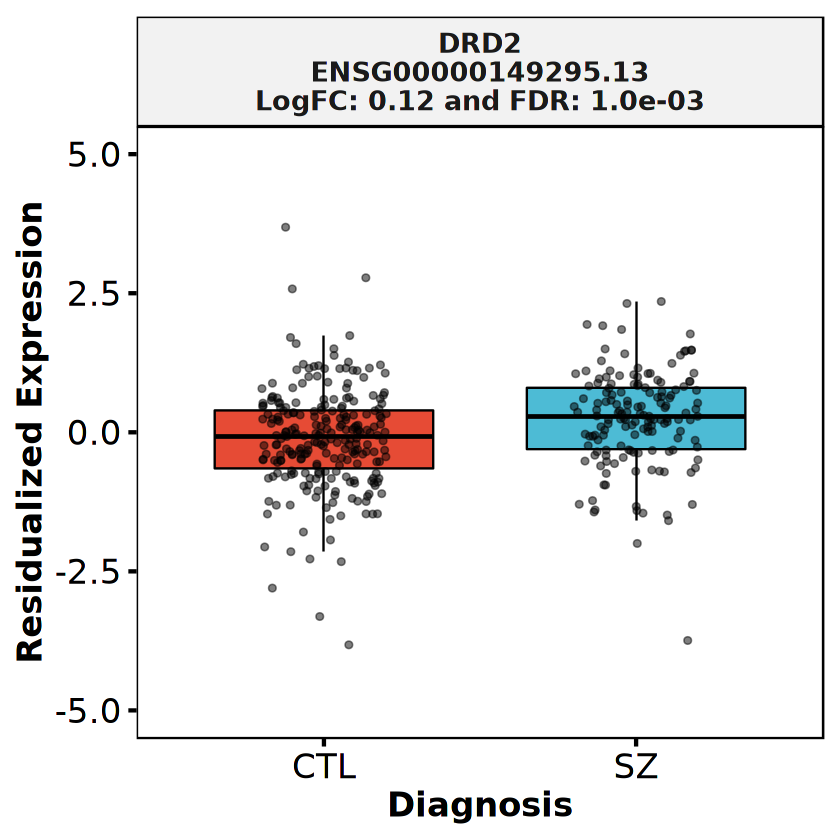

In [4]:
feature = "genes"

bxp = memDF(feature) %>% 
    mutate(ID=paste0("DRD2\n", Feature, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                     formatC(`adj.P.Val`, format = "e", digits = 1))) %>% 
    mutate_if(is.character, as.factor) %>% 
    ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
              add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), xlab="Diagnosis",
              panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
              add.params=list(alpha=0.5), outlier.shape=NA, ylim=c(-5, 5), 
              legend="None") +
    font("xy.title", face="bold")
save_ggplots(bxp, "drd2_gene_boxplot", 6, 6)
bxp

## Transcripts

Warning message in data.table::fread(filename):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


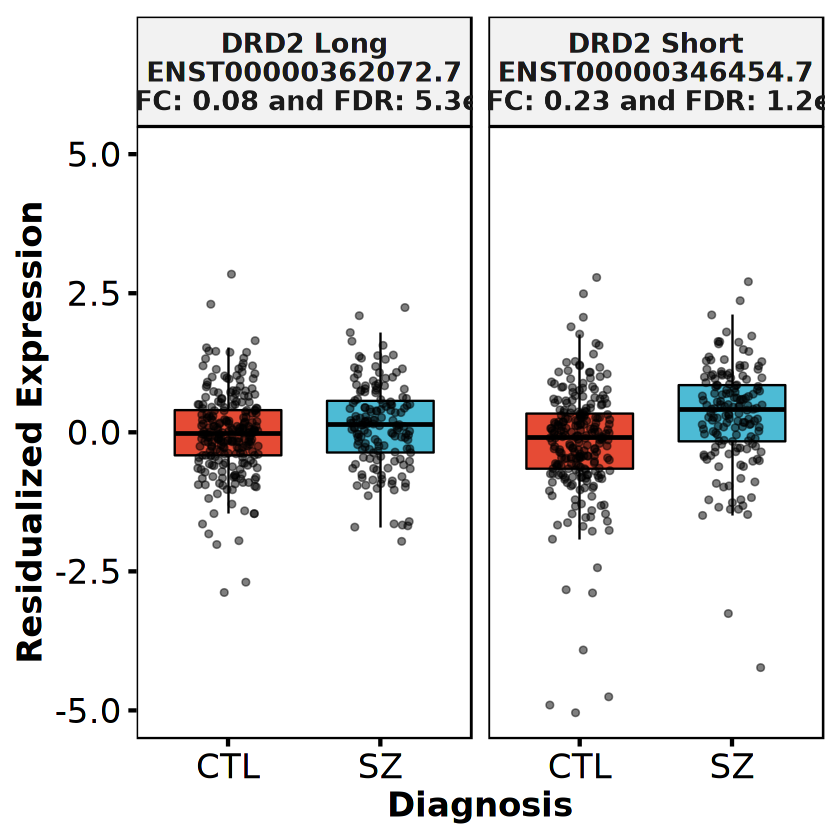

In [5]:
feature = "transcripts"

bxp = memDF(feature) %>% filter(Feature %in% c("ENST00000362072.7", "ENST00000346454.7")) %>%
    mutate(DRD2_ID=ifelse(Feature == "ENST00000362072.7", "DRD2 Long", "DRD2 Short")) %>% 
    mutate(ID=paste0(DRD2_ID, "\n", Feature, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                     formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
    mutate_if(is.character, as.factor) %>% 
    ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
              add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
              xlab="Diagnosis", legend="None", ylim=c(-5, 5), outlier.shape=NA, 
              panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
              add.params=list(alpha=0.5)) +
    font("xy.title", face="bold")
save_ggplots(bxp, "drd2_transcripts_boxplot", 9, 6)
bxp

In [6]:
dir.create(feature)
for(feature_id in c("ENST00000362072.7", "ENST00000346454.7")){
    drd2_id = ifelse(feature_id == "ENST00000362072.7", "DRD2 Long", "DRD2 Short")
    bxp = memDF(feature) %>% filter(Feature == feature_id) %>% mutate(DRD2_ID=drd2_id) %>% 
        mutate(ID=paste0(DRD2_ID, "\n", Feature, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                         formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
        mutate_if(is.character, as.factor) %>% 
        ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
                  add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
                  xlab="Diagnosis", outlier.shape=NA, ylim=c(-5, 5), legend="None",
                  panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
                  add.params=list(alpha=0.5)) +
        font("xy.title", face="bold")
    save_ggplots(bxp, paste0(feature,"/drd2_transcripts_boxplot_", gsub(" ", "_", drd2_id)), 6, 6)
}

## Exons

Warning message in data.table::fread(filename):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


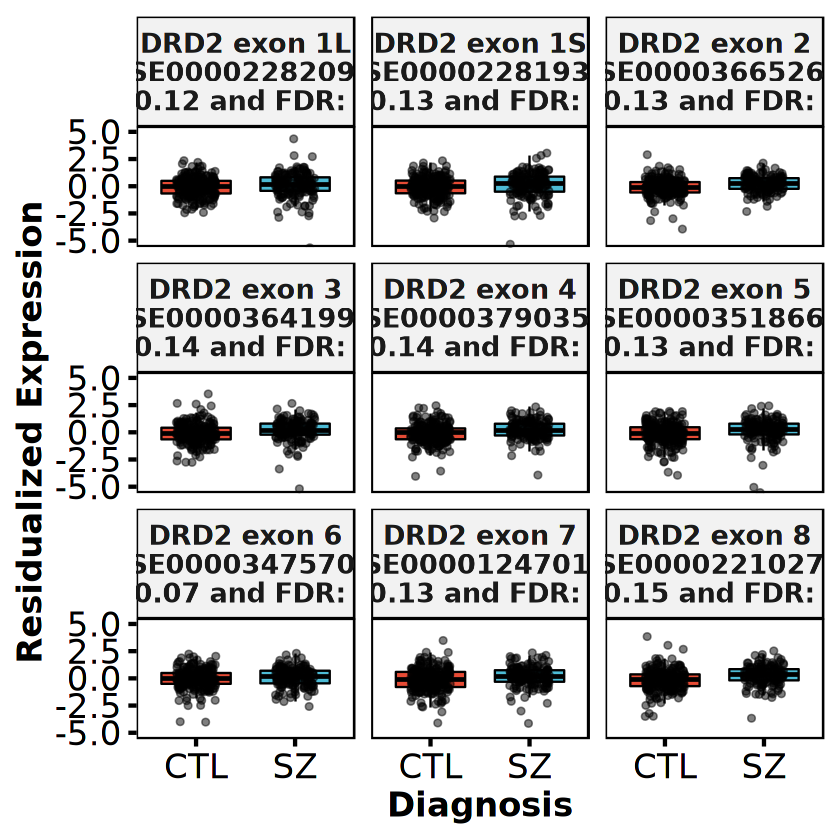

In [7]:
feature = "exons"

bxp = memDF(feature) %>% inner_join(annotate_drd2_exons(), by=c("Feature"="brainseq_exon_id")) %>%
    mutate(ID=paste0(DRD2_ID, "\n", exon_id, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                     formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
    mutate_if(is.character, as.factor) %>% 
    ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
              add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
              xlab="Diagnosis", outlier.shape=NA, ylim=c(-5, 5), legend="None",
              panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
              add.params=list(alpha=0.5)) +
    font("xy.title", face="bold")
save_ggplots(bxp, "drd2_exons_boxplot", 12, 12)
bxp

In [8]:
dir.create(feature)
for(feature_id in annotate_drd2_exons()$brainseq_exon_id){
    drd2_id = filter(annotate_drd2_exons(), brainseq_exon_id == feature_id)$DRD2_ID
    bxp = memDF(feature) %>% filter(Feature == feature_id) %>% 
        inner_join(annotate_drd2_exons(), by=c("Feature"="brainseq_exon_id")) %>% 
        mutate(ID=paste0(DRD2_ID, "\n", exon_id, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                         formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
        mutate_if(is.character, as.factor) %>% 
        ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
                  add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
                  xlab="Diagnosis", outlier.shape=NA, ylim=c(-5, 5), legend="None",
                  panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
                  add.params=list(alpha=0.5)) +
        font("xy.title", face="bold")
    save_ggplots(bxp, paste0(feature,"/drd2_exons_boxplot_", gsub(" ", "_", drd2_id)), 6, 6)
}

## Junctions

Warning message in data.table::fread(filename):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


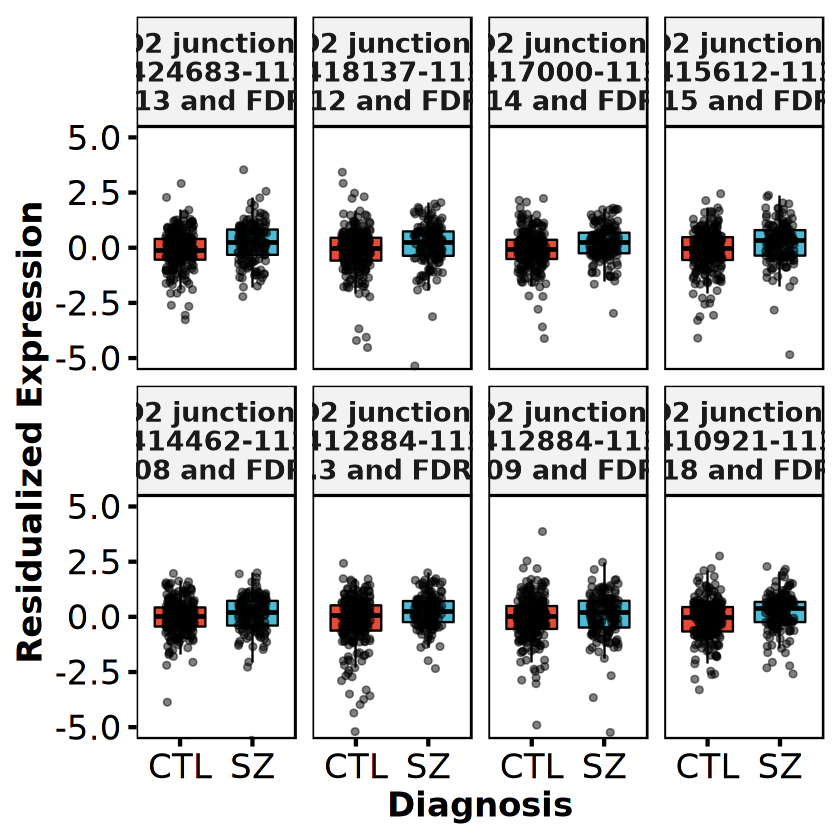

In [9]:
feature = "junctions"

bxp = memDF(feature) %>% inner_join(annotate_drd2_junctions(), by=c("Feature")) %>%
    mutate(ID=paste0(DRD2_ID, "\n", Feature, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                     formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
    mutate_if(is.character, as.factor) %>% 
    ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
              add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
              xlab="Diagnosis", outlier.shape=NA, ylim=c(-5, 5), legend="None",
              panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
              add.params=list(alpha=0.5), ncol=4) +
    font("xy.title", face="bold")
save_ggplots(bxp, "drd2_junctions_boxplot", 16, 10)
bxp

In [10]:
dir.create(feature)
for(feature_id in annotate_drd2_junctions()$Feature){
    drd2_id = filter(annotate_drd2_junctions(), Feature == feature_id)$DRD2_ID
    bxp = memDF(feature) %>% filter(Feature == feature_id) %>% 
        inner_join(annotate_drd2_junctions(), by=c("Feature")) %>% 
        mutate(ID=paste0(DRD2_ID, "\n", Feature, "\nLogFC: ", round(logFC, 2), " and FDR: ", 
                         formatC(`adj.P.Val`, format = "e", digits = 1))) %>%
        mutate_if(is.character, as.factor) %>% 
        ggboxplot(x="Dx", y="Residualized", fill="Dx", facet.by="ID", palette="npg", 
                  add="jitter", ggtheme=theme_pubr(base_size=20, border=TRUE), 
                  xlab="Diagnosis", outlier.shape=NA, ylim=c(-5, 5), legend="None",
                  panel.labs.font=list(face='bold'), ylab="Residualized Expression", 
                  add.params=list(alpha=0.5)) +
        font("xy.title", face="bold")
    save_ggplots(bxp, paste0(feature, "/drd2_junctions_boxplot_", 
                             gsub("-", "_", gsub(" ", "_", drd2_id))), 6, 6)
}

## Session Info

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-09-06 08:47:21 EDT"

   user  system elapsed 
 75.067  41.450  90.154 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-09-06                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.9    2021-07-27 [1] CRAN (R 4.0.3)
 cachem        1.0.6    2021-08-19 [1] CRAN (R 